# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)


In [109]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
import geopandas as gpd #For importing shapefiles
import shapely as shp #For handling shapely geometries
from shapely import vectorized # For building the idomain using vector arrays
import networkx as nx #For handling creek networks and pathways
import geojson #For handling geojson files
import imageio.v2 as imageio #For making GIFs of head distributions
from datetime import datetime, timedelta #For creating datetime timeseries for plotting
import shutil as shutil #For saving and creating directories of head plots in transient
import pygeos #For handling geographic data
from pygeos import STRtree #For handling geographic data in stringtrees
import random

## Load External Data

Import the watershed data (HUC - 12)  
Import the Sinkhole and Spring Data  
Import the Bear Spring Discharge Data  
Import the Groundwater Elevation Data from the MRSW  
Import the Recharge Data from Zixuan

In [110]:
#Load the Watershed Extent data from USGS StreamStats
geoJSON = './data/HUC_12.geojson'
watershed = gpd.read_file(geoJSON)
projected_crs = 'EPSG:32615'
watershed = watershed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
watershed_types = watershed.geometry.type.unique()
print(f'The data types in watershed_types is: {watershed_types}')

#Generate a Polygon object from the watershed geoJSON
wsPolygon = watershed[watershed.geometry.type == 'Polygon']
#repair the geometry for any errors that make the polygon not valid
wsPolygon.loc[:,'geometry'] = wsPolygon['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {wsPolygon.is_valid}')

#get the bounding box for the watershed polygon
bounds = wsPolygon.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Get the area of the watershed polygon
wsArea = wsPolygon['geometry'].area.sum()
print(f'Watershed area: {wsArea/1e6:.2f} Km^2')

#Import the karst feature data (UTME, UTMN, elevation data)
f = pl.Path('./data/karst_features.csv')
karst_df = pd.read_csv(f)
karst_df = karst_df.set_index("ID") #Set the index for the karst dataframe to the feature name
karst_df['Elevation_m'] = karst_df['Elevation_ft'] * 0.3048 # create a new col. with the m elevation

#Isolate the spring and sinkhole coordinates for plotting on DEM
springs = karst_df[karst_df['Type'] == 'spring' ] #get springs
sinkholes = karst_df[karst_df['Type'] == 'sink' ] #get sinkholes

#Import the creek data shapefile
creeks = gpd.read_file('./data/creeks_geoJSON.geojson')
creeks = creeks.to_crs(wsPolygon.crs) #Set the coordinate reference system for the shapefile
creeks = gpd.clip(creeks, wsPolygon) #Mask out all the shapefile data that is not inside of the wsPolygon

#Import the sinkhole coords that have NOT been traced
untracedSinks = np.loadtxt('./data/bear_sinkholes_coords.txt')

#Get the Marion Rest Stop Well data
f = pl.Path('./data/steady_state/2017_MRSW_year_FINAL.csv')
obsGWE_df = pd.read_csv(f, parse_dates=["datetime"], index_col="datetime")
#Convert the index to datetime objects
obsGWE_df.index = pd.to_datetime(obsGWE_df.index)
#Get rid of any NaN rows produced by the data filtering outside of python
obsGWE_df.dropna(inplace=True)
#Convert all of the 0 values to NaN values (missing data)
obsGWE_df.replace(0, np.nan, inplace=True)

#Get the recharge data from zixuan (Hourly, entire year)
f = pl.Path('./data/steady_state/2017_recharge_year_FINAL.csv')
rch_df = pd.read_csv(f,parse_dates=['DATE'], index_col='DATE')
#Set the indices of the dataframe to be datetime objects
rch_df.index = pd.to_datetime(rch_df.index)
#Set the average recharge over the entire year for use in the steady-state model
rch_avg = rch_df['RCH[m/day]'].mean()
print(f'The average recharge is: {rch_avg} m/day')

#Get the year discharge data
f = pl.Path('./data/steady_state/discharge_full_year_2017.csv')
dis_df = pd.read_csv(f, parse_dates=['Date'], index_col = 'Date')
dis_df.index = pd.to_datetime(dis_df.index)
dis_avg = dis_df['Q [m3/day]'].mean()
print(f'The average discharge is: {dis_avg} m3/day')

The data types in watershed_types is: ['Point' 'Polygon']
The polygon is Valid: 1    True
dtype: bool
min x: 552414.3972794723, min y: 4865615.877233875, max x: 561054.4101949929, max y: 4874795.869936911
Watershed area: 51.41 Km^2
The average recharge is: 0.0010841048580162197 m/day
The average discharge is: 3965.1518814924925 m3/day


In [111]:
#Import the springshed polygon data
geoJSON = './data/Bear_Springshed.geojson'
springshed = gpd.read_file(geoJSON) #Create a gpd object from the geoJSON object
projected_crs = 'EPSG:32615' #Establsih a coordinate reference system for the model (CRS)
springshed = springshed.to_crs(projected_crs) # Apply the CRS to the springshed gpd object

#Check for geometry types (need to extract a polygon dataset)
springshed_types = springshed.geometry.type.unique()
print(f'The data tpyes in the springshed geoJSON: {springshed_types}')

#Generate a Polygon object from the watershed geoJSON
bsPolygon = springshed[springshed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
bsPolygon.loc[:,'geometry'] = bsPolygon['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {bsPolygon.is_valid}')
bsPolygon = bsPolygon.explode(index_parts=True)

#Print the area of Bear Springshed
bsArea = bsPolygon['geometry'].area.sum()
print(f'Springshed Area: {bsArea/1e6:.2f} Km^2')


The data tpyes in the springshed geoJSON: ['Polygon']
The polygon is Valid: 0    True
dtype: bool
Springshed Area: 4.63 Km^2


### Generate Helper Functions  
To be used later in the code for accessing cells with specific attributes

In [112]:
#Get karst feature data from karst_df
def get_karst_data(ID):
    return karst_df.loc[ID].to_dict()

#Get DEM elevation data, cell row and column for a karst feature point
def get_cell_elev(ID):
    k_feat = get_karst_data(ID)
    i, j = sg.intersect(k_feat['UTME'], k_feat['UTMN'])
    elev = dem_grid[i,j]
    #print(f'Feature ID: {ID},row: {i}, col: {j}, DEM_elev: {elev}')
    return elev, i, j

#method used in order to assign creek cells and to pass attributes to these cells used as drains later
#in the boundary construction processes
def get_creek_cells(creek, sg, dem_grid, idomain, conductance=50):
    river_cells = set()

    # Convert creek geometry to PyGEOS geometries
    creek_geoms = [pygeos.linestrings(line.coords) for line in creek.geometry]
    creek_tree = STRtree(creek_geoms)

    # Iterate through grid cells
    for i in range(sg.nrow):
        for j in range(sg.ncol):
            if idomain[0, i, j] == 1:  # Only check active cells
                # Get cell vertices and create a PyGEOS Polygon
                vertices = sg.get_cell_vertices(i, j)
                cell_poly = pygeos.polygons(vertices)

                # Query the spatial index for intersecting creek geometries
                intersecting_indices = creek_tree.query(cell_poly, predicate="intersects")

                # If there are intersections, record the cell
                if len(intersecting_indices) > 0:
                    elev = dem_grid[i, j]
                    river_cells.add((0, i, j, elev, conductance))

    return list(river_cells)

#Get locations of cells in list form
nrow = None #Just to get the error to stop showing up (is defined later)
ncol = None #Just to get the error to stop showing up (is defined later)

#Get locations of cells in list form
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes

## Build the domain from the above GeoJSON, shapefiles

/tmp/ipykernel_3016763/386116323.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


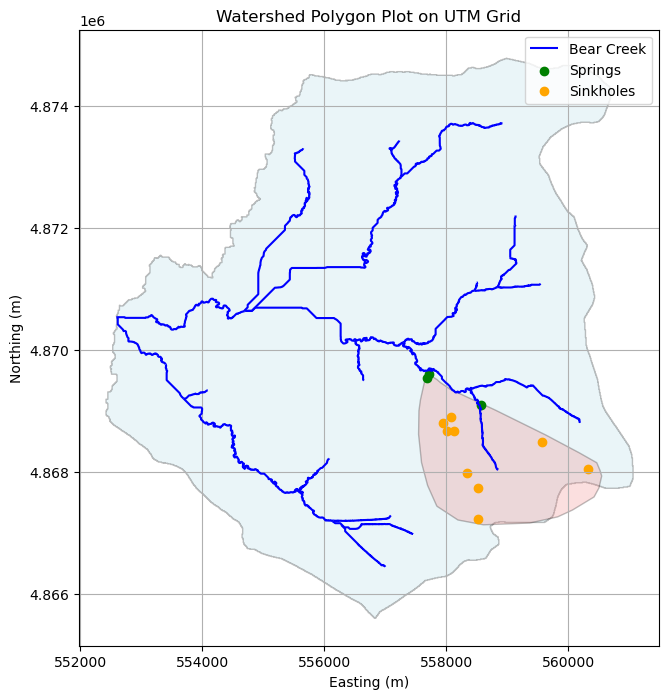

In [113]:
# Plot the polygon using the correct CRS to ensure that the bounds are in the right coordinate system and that the polygon looks correct
fig, ax = plt.subplots(figsize=(8, 8))
wsPolygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha = 0.25, label = 'Watershed Area') #Plot the watershed Polygon
bsPolygon.plot(ax=ax, color='lightcoral', edgecolor='black', alpha = 0.25, label = 'Springshed Area') #Plot the Bear Spring Polygon
creeks.plot(ax=ax, color='blue', label='Bear Creek') #Plot the creeks object on the map
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.legend()

### Combine the Watershed Polygon with the Springshed Polygon

The polygon is Valid: 0    True
dtype: bool


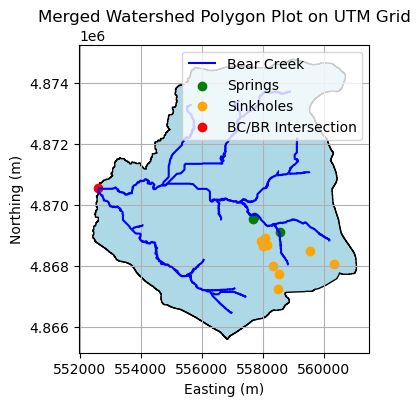

In [114]:
#Combine the polygons into a collective list
polygons = list(wsPolygon['geometry']) + list(bsPolygon['geometry'])

#Merge the polygon list into a singular polygon covering the watershed and springshed area
merged = shp.ops.unary_union(polygons)

#Convert the merged polygon to a GeoDataFrame (gdf) object
wsMerged = gpd.GeoDataFrame([{'geometry': merged}], crs=projected_crs)

#repair the geometry for any errors that make the polygon not valid
wsMerged.loc[:,'geometry'] = wsMerged['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {wsMerged.is_valid}')
wsMerged = wsMerged.explode(index_parts=True)

#Plot the new domain shape from the merged polygons
label = False #Flag for turning the creek linestring labels on/off (used for creek boundary adjustments)
fig, ax = plt.subplots(figsize=(4, 4))
wsMerged.plot(ax=ax, color = 'lightblue', edgecolor = 'black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')

#Label each of the linestrings for the creeks GDF so that they can be isolated for further boundary refinement
if label == True:
    for _, creek in creeks.iterrows():
        creek_geom = creek['geometry']

        midpoint = creek_geom.interpolate(0.5, normalized = True)

        ax.text(midpoint.x, midpoint.y, str(creek['FID']), color='k', fontsize=12, ha='center')

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Merged Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.scatter(552594.407, 4870544.353, color='red', label ='BC/BR Intersection') #Plot the point where Bear Creek and Badger Run meet
plt.legend()
plt.show()
#Get the new bounds of the merged polygon
bounds = wsMerged.total_bounds

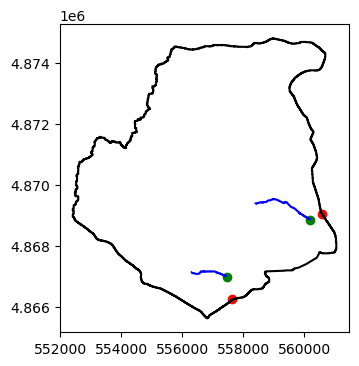

In [115]:
#Select the stream segments to extend to the watershed boundary
fids = [186, 154] #Unique FIDs that represent the Easternmost and Southernmost end streams to connect w/ border
select_creeks = creeks[creeks['FID'].isin(fids)] #Get the creek linestring objects associated with the FIDS

#get the point coordinates associated with the end of the creek strings and the border of the model
coords0 = list(select_creeks.iloc[0].geometry.coords)[-1] #Collect the coordinates
coords0 = shp.geometry.Point(coords0) #Convert coordinates to point objects
coords1 = list(select_creeks.iloc[1].geometry.coords)[-1] #Collect the coordinates
coords1 = shp.geometry.Point(coords1) #convert coordinates to shapely point objects

#Get the boundary for the watershed
wsBoundary = wsMerged.geometry.iloc[0].boundary #Get the boundary object from the entire watershed

#Find the nearest points from the end of the selected creeks to the boundary
nearest0 = shp.ops.nearest_points(coords0, wsBoundary) 
nearest1 = shp.ops.nearest_points(coords1, wsBoundary)
nearest_point0 = nearest0[1]
nearest_point1 = nearest1[1]

#Plot the new points
fig, ax = plt.subplots(figsize=(4, 4))
wsMerged.boundary.plot(ax=ax, color = 'k', edgecolor = 'black')
select_creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.scatter(nearest_point0.x, nearest_point0.y, color = 'red')
plt.scatter(coords0.x, coords0.y, color = 'green')
plt.scatter(nearest_point1.x, nearest_point1.y, color = 'red')
plt.scatter(coords1.x, coords1.y, color = 'green')

#Now add in the line segment connecting the
#creeks to the boundary cells nearest to them
#build new line segments
segment0 = shp.geometry.LineString([coords0, nearest_point0])
segment1 = shp.geometry.LineString([coords1, nearest_point1])

#convert line segments to geodataframe objects so that they can be used for domain manipulation
segment0_gdf = gpd.GeoDataFrame(
    {'FID': [max(select_creeks['FID']) + 1]},  # Assign a unique FID
    geometry=[segment0],
    crs=select_creeks.crs  # Use the same CRS as the original creeks GeoDataFrame
)

segment1_gdf = gpd.GeoDataFrame(
    {'FID': [max(select_creeks['FID']) + 1]},  # Assign a unique FID
    geometry=[segment1],
    crs=select_creeks.crs  # Use the same CRS as the original creeks GeoDataFrame
)

### Connect the Existing Creek Boundary to the edge of the Watershed Polygon

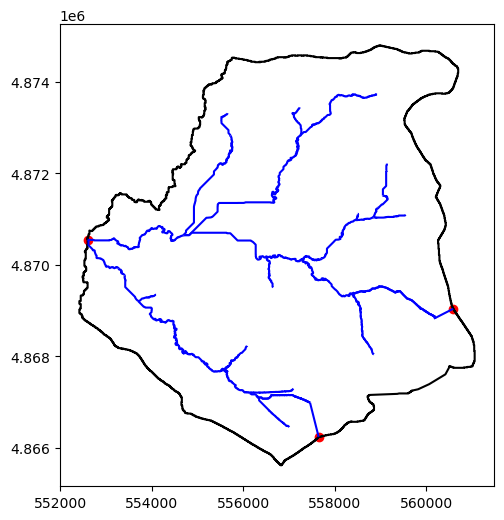

In [116]:
#Combine the creeks together with the selected creeks
new_creeks = pd.concat([select_creeks, segment0_gdf], ignore_index=True)
new_creeks = pd.concat([new_creeks, segment1_gdf], ignore_index=True)

#combine the newly made creeks with the existing creek deliniations
creeks = pd.concat([creeks, new_creeks], ignore_index=True)

#Find the intersection points where the boundary intersects with the creek
intersections = creeks.geometry.apply(lambda line: line.intersection(wsBoundary))
intersections_points = intersections[intersections.geom_type == "Point"]

unique_points = list({(point.x, point.y) for point in intersections_points})

#Plot the new creeks and the intersection points on a plot
label = False #Flag for turning the creek linestring labels on/off
fig, ax = plt.subplots(figsize=(6, 6))
wsMerged.boundary.plot(ax=ax, color = 'k', edgecolor = 'black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')
for i in range(len(unique_points)):
    plt.scatter(unique_points[i][0], unique_points[i][1], color='red')

if label == True:    
    for _, creek in creeks.iterrows():
        creek_geom = creek['geometry']

        midpoint = creek_geom.interpolate(0.5, normalized = True)

        ax.text(midpoint.x, midpoint.y, str(creek['FID']), color='k', fontsize=12, ha='center')

### Isolate the area between the Three points as the new Subdomain

[(560584.4090987638, 4869035.8773543835), (557644.4070525824, 4866235.880722723), (552594.4065552499, 4870544.35311871)]
Subdomain Area: 18.75 Km^2


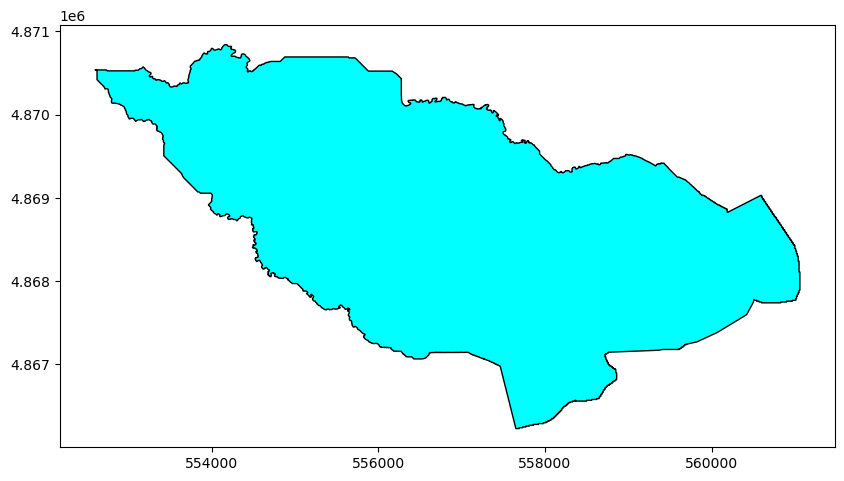

In [117]:
#Use the selected points above to generate a new domain
print(unique_points)

#Create a networkx graph object
G = nx.Graph()
#Define a function to find the shortest path from each point through the creek network
for idx, line in creeks.iterrows():
    coords = list(line.geometry.coords)
    G.add_edge(tuple(coords[0]), tuple(coords[-1]), geometry = line.geometry)
    
#build a fxn for finding the shortest path between two points in a network
def find_shortest_path(G, start_point, end_point):
    #Find the nearest node for the start and end points
    start_node = min(G.nodes, key=lambda node: shp.geometry.Point(node).distance(start_point))
    end_node = min(G.nodes, key=lambda node: shp.geometry.Point(node).distance(end_point))
    
    #find the shortest path between these nodes
    path = nx.shortest_path(G, source=start_node, target=end_node)
    return path

#Convert the coordinate tuples to point objects
points = [shp.geometry.Point(coords) for coords in unique_points]

#find shortest path along creeks
pathAC = find_shortest_path(G, points[0], points[2])
pathBC = find_shortest_path(G, points[1], points[2])

#Convert these paths (sets of nodes) into LineStrings
linesAC = [G.edges[pathAC[i], pathAC[i + 1]]['geometry'] for i in range(len(pathAC) - 1)]
linesBC = [G.edges[pathBC[i], pathBC[i + 1]]['geometry'] for i in range(len(pathBC) - 1)]

#Merge these lines into continuous paths
AC = shp.ops.linemerge(linesAC)
BC = shp.ops.linemerge(linesBC)

#Get the domain boundary along the watershed boundary
# Convert LineString to a list of coordinates
boundary_coords = list(wsBoundary.coords)

# Find nearest boundary coordinates for Points A and B
def find_nearest_index(coords, point):
    return np.argmin([shp.ops.Point(c).distance(point) for c in coords])

index_a = find_nearest_index(boundary_coords, points[0])
index_b = find_nearest_index(boundary_coords, points[1])

# Create two paths: clockwise and counterclockwise
if index_a < index_b:
    path1 = boundary_coords[index_a:index_b + 1]
    path2 = boundary_coords[index_b:] + boundary_coords[:index_a + 1]
else:
    path1 = boundary_coords[index_b:index_a + 1]
    path2 = boundary_coords[index_a:] + boundary_coords[:index_b + 1]

# Convert paths to LineStrings and select the shorter one
path1_ls = shp.geometry.LineString(path1)
path2_ls = shp.geometry.LineString(path2)

wsSegment = path1_ls if path1_ls.length < path2_ls.length else path2_ls

#Get the boundary for the creek paths developed above
#Get the projected points on the constructed lines

#AC
AC_start = AC.project(points[0])
AC_end = AC.project(points[2])
acSegment = shp.ops.substring(AC, AC_start, AC_end)

#BC
BC_start = BC.project(points[1])
BC_end = BC.project(points[2])
bcSegment = shp.ops.substring(BC, BC_start, BC_end)

#Convert to a singular shape
subDomain_coords = (
    list(acSegment.coords) +
    list(bcSegment.coords[::-1]) +
    list(wsSegment.coords[::-1])
)

#create trianlge Polygon
subDomain_poly = shp.geometry.Polygon(subDomain_coords)

#Convert to GDF object
# Plot the result
subDomain = gpd.GeoDataFrame(
    {'geometry': [subDomain_poly]},
    crs=wsMerged.crs  # Use CRS of your original data
)

subArea = subDomain['geometry'].area.sum()/1e6
print(f'Subdomain Area: {subArea:.2f} Km^2')

#subDomain is the new domain that is selected between the two creeks
# Plot
ax = subDomain.plot(color="cyan", edgecolor="black", figsize=(10, 8))
plt.show()


## Apply the subdomain above to the DEM

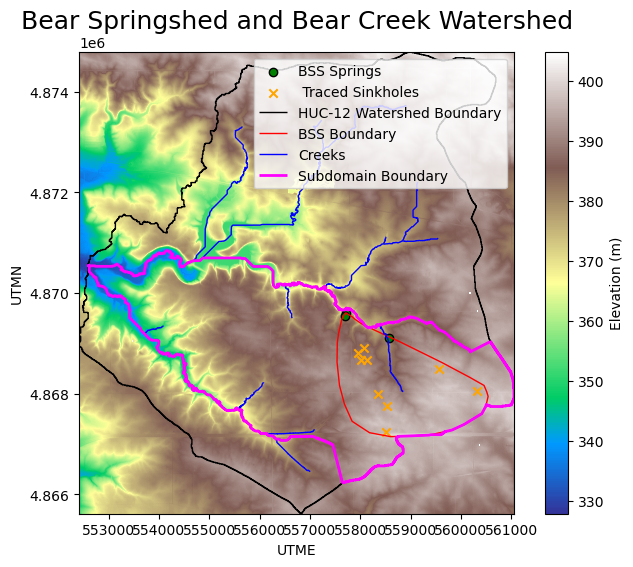

Current UTM Boundary: 552414.3972794723
Current UTM Boundary: 4865615.877233875
Current UTM Boundary: 561054.4101949929
Current UTM Boundary: 4874795.869936911


In [118]:
#Import the DEM data
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    # Define the window of useful data (in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)  # Get window boundaries to confirm they are correct
    
    # Read only the windowed portion of the DEM
    dem_data = src.read(1, window=window)
    
    # Mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_data = np.ma.masked_where(dem_data > maxval, dem_data)
    
    # Get the corresponding transform for plotting
    window_transform = src.window_transform(window)
    
# Plot DEM as a color plot to evaluate all of the values and establish the value range and units
fig, ax = plt.subplots(figsize=(8, 6))
dem_plot = ax.imshow(
    dem_data,
    cmap='terrain',
    extent=[extent[0], extent[2], extent[1], extent[3]],
    origin='upper'
)
# Add a colorbar for the DEM
cbar = plt.colorbar(dem_plot, ax=ax, label='Elevation (m)')
# Plot springs and sinkholes on the DEM
ax.scatter(
    springs['UTME'], springs['UTMN'],
    color='green', label='BSS Springs', marker='o', edgecolor='black'
)
ax.scatter(
    sinkholes['UTME'], sinkholes['UTMN'],
    color='orange', label=' Traced Sinkholes', marker='x'
)

# Overlay the merged watershed (wsMerged GeoDataFrame)
wsMerged.boundary.plot(ax=ax, color='k', linewidth=1, label='HUC-12 Watershed Boundary')
#Overlay the Springshed Area (Should be within the merged area)
bsPolygon.boundary.plot(ax=ax, color ='red', linewidth=1, label ='BSS Boundary')
#Overlay the creeks
creeks.plot(ax=ax, color= 'blue', linewidth=1, label='Creeks')
#overlay the subdomain area between the creeks
subDomain.boundary.plot(ax=ax, color= 'magenta', label= 'Subdomain Boundary', linewidth = 2)
# Add labels and title
ax.set_xlabel('UTME')
ax.set_ylabel('UTMN')
ax.set_title('Bear Springshed and Bear Creek Watershed', fontsize = 18)
ax.legend()

plt.show()

#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [119]:
#Construct a new set of bounds using the newly formed polygon
bounds = subDomain.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Re-adjust the cell size, domain of the model, ncol, nrow, based on the domain change
Lx = bounds[2] - bounds[0]
Ly = bounds[3] - bounds[1]
delr = 5.0 #m we Know that these values work quite well with the given KhCond and Kh
delc = 5.0 #m we know that these values work quite well with the given Khcond and Kh
#delr = 1.0 #m
#delc = 1.0 #m
ncol = int(Lx / delc)
nrow = int(Ly / delr)

#Re-import the new DEM_Grid with the updated boundaries from the subDomain
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    #define the window of useful data(in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)#get window boundaries to confirm they are correct
    
    #convert all of the data to a grid so it can be used with the MODFLOW model
    width = ncol#set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling= rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)

min x: 552594.4065552499, min y: 4866235.880722723, max x: 561054.4101949929, max y: 4870845.353118716


### Build Out the Modflow structured Grid

In [120]:
#generate the grid properties top, bottom, nlay, that are not defined in the grid construction above
nlay = 1
top = dem_grid #Set the upper elevation boundary for the single layer model
botm = np.ones((nlay, nrow, ncol), dtype = float) #contruct the array which will beomce the bottom array
botm_elev = 325.044 #Top of the decorah shale THIS VALUE IS NOT CORRECT, ONLY IN TEMPORARILY
#assign elevations for bottoms of the units
botm[0] = botm_elev #This will eventually be changed by the angled botm array

#Convert delc and delr to an array for input into the sg object
delr = delr * np.ones(ncol, dtype = float)
delc = delc * np.ones(nrow, dtype = float)

# Generate the model grid in flopy
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds[0],
    yoff=bounds[1],
    crs= 'EPSG:32615'
)

### Get the Coordinates for the sinkholes and the springs and store them

In [121]:
#Get all of the coordinates for the sinkholes
sinkhole_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'sink'])):
    df = karst_df[karst_df['Type'] == 'sink']
    sinkhole = df.iloc[i]
    elev, row, col = get_cell_elev(sinkhole.name)
    sinkhole_cells.append((sinkhole.name, elev, row, col))
    
#Add the untraced sinkholes to the list to get an entire list
for j in range(len(untracedSinks)):
    x = untracedSinks[j][0]
    y = untracedSinks[j][1]
    i, j = sg.intersect(x, y)
    sinkhole_cells.append(('Untraced', 0.00, i, j))

#get all of the coordinates for the springs (NOT including Bear Spring)
spring_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'spring'])):
    df = karst_df[karst_df['Type'] == 'spring']
    spring = df.iloc[i]
    elev, row, col = get_cell_elev(spring.name)
    spring_cells.append((spring.name, elev, row, col))

### Build the idomain array using vector operations  
Generally, this tends to be one of the slower steps in the model, especially at high resolution

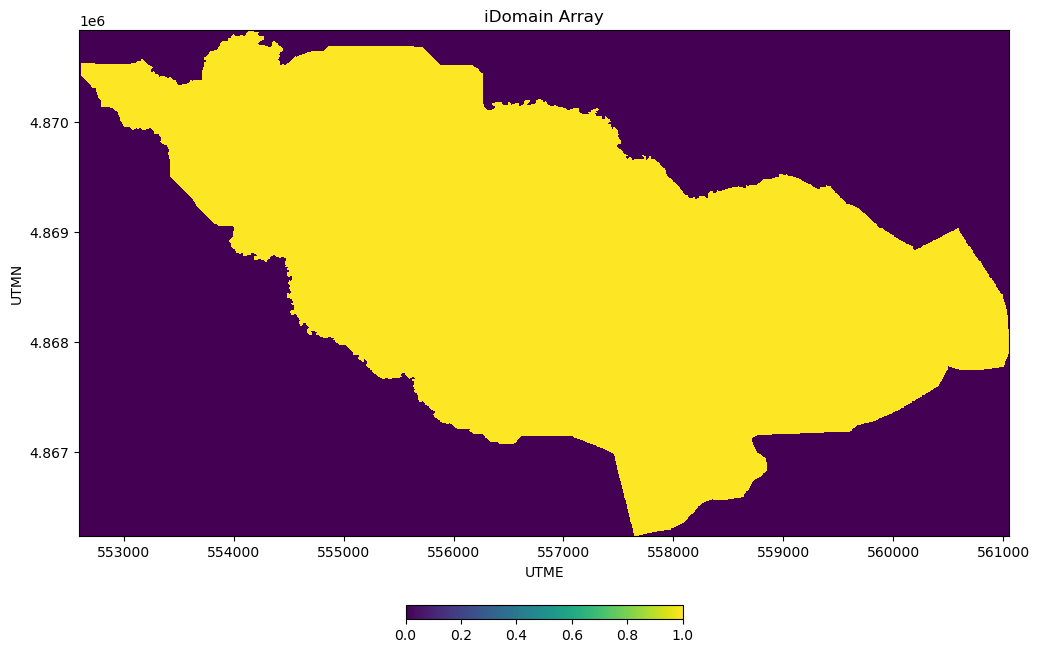

In [122]:
#idomain method based on vectorization and numpy ## This appears to be the fastsest of all the methods
xc, yc = sg.xcellcenters, sg.ycellcenters #Get the cell center coords
points = np.array([(xc[i, j], yc[i, j]) for i in range(nrow) for j in range(ncol)])

#Extract the raw polygon from the GDF object subDomain
domain = subDomain.geometry.values[0]
domain = domain.buffer(0)
gi = flopy.utils.GridIntersect(sg)
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
mask = vectorized.contains(domain, points[:, 0], points[:, 1])
idomain_mask = mask.reshape((nrow, ncol))
idomain[:, :, :] = idomain_mask.astype(int)

#Plot the idomain array for each layer of the model    
fig, ax = plt.subplots(figsize=(12,9))  # Create subplots in a single row
pmv = flopy.plot.PlotMapView(modelgrid=sg, layer=1)
cb = pmv.plot_array(idomain[0], ax=ax)
fig.colorbar(cb, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, shrink=0.8)
plt.title('iDomain Array')
plt.xlabel('UTME')
plt.ylabel("UTMN")
plt.show()

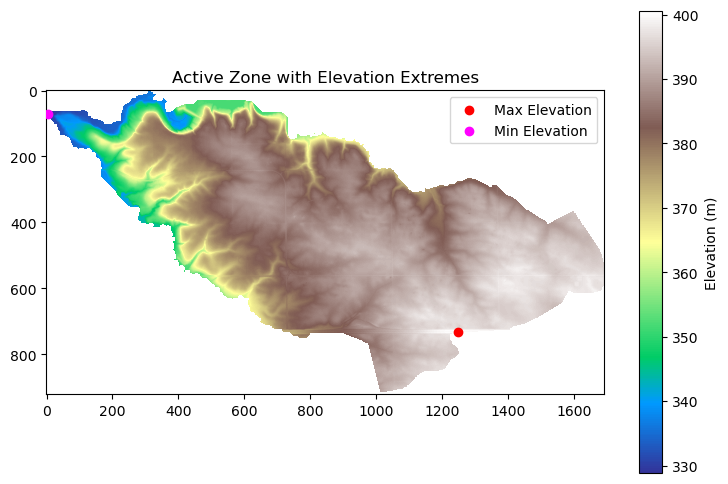

The overall surface slope of the watershed is 1.02 % to the NW
The overall slope of the watershed in degrees is 0.58 degrees
The azimuth of the slope (max elev to min elev) is 298.07 degrees


In [123]:
#Apply the DEM to the subDomain area and use it to generate a bottom array

#Calculate the slope from the highest point in the active zone to the loweset point in the active zone
# Mask the DEM for the active zone
activeDEM = np.ma.masked_where(idomain[0] == 0, dem_grid)

# Find max and min elevations within the active zone
activeMax = np.max(activeDEM)
activeMin = np.min(activeDEM)

# Get the indices of max and min elevations in the masked array
maxIndex = np.unravel_index(np.argmax(activeDEM), activeDEM.shape)
minIndex = np.unravel_index(np.argmin(activeDEM), activeDEM.shape)

# Plot the DEM with the max and min points
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
im = ax.imshow(activeDEM, cmap='terrain', origin='upper')
plt.colorbar(im, ax=ax, label='Elevation (m)')
ax.scatter(maxIndex[1], maxIndex[0], color='red', label='Max Elevation', zorder=10)
ax.scatter(minIndex[1], minIndex[0], color='magenta', label='Min Elevation', zorder=10)
ax.legend()
ax.set_title('Active Zone with Elevation Extremes')
plt.show()

#calculate the distance between these two points in m
#Get the UTME and UTMN coordinates for each of the cells
UTME1 = bounds[0] + (maxIndex[1] + 0.5) * np.average(delc)
UTME2 = bounds[0] + (minIndex[1] + 0.5) * np.average(delc)

UTMN1 = bounds[1] + (100 - maxIndex[0] + 0.5) * np.average(delr) # 100 - because the plot here counts down on the y axis
UTMN2 = bounds[1] + (100 - minIndex[0] + 0.5) * np.average(delr) # 100 - becaues the  plot here counts down on the y axis

#Calculate the distance between each point, the elevation difference, and the slope
wsH = activeMax - activeMin
wsL = np.sqrt((UTME1-UTME2)**2 + (UTMN1-UTMN2)**2)
wsSlope = wsH/wsL
print(f'The overall surface slope of the watershed is {(wsSlope* 100):.2f} % to the NW')
slopeDeg = np.arctan(wsSlope) * 180/np.pi
print(f'The overall slope of the watershed in degrees is {slopeDeg:.2f} degrees')

#determine the azimuth of the slope (to the NW)
az = np.arctan((UTME1-UTME2)/(UTMN1-UTMN2))
azDeg = az * (180/np.pi) + 360 #adding 360 because we want in azimuth convention
print(f'The azimuth of the slope (max elev to min elev) is {azDeg:.2f} degrees')

#The next step is to actually apply this azimuth and the known slope to create a bottom surface that slopes at ~1 degree in the same direction as the surface

### Build Out the Bottom Array using the bottom surface slope of the model

Max elev of the Sloped bottom array 352.044
Min elev of the sloped bottom array 254.01860859793595


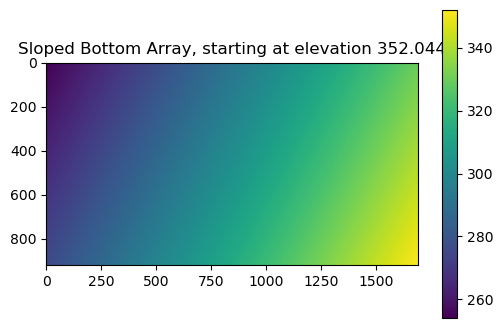

In [124]:
# Convert slope and azimuth to radians
slopeRad = np.radians(slopeDeg)
azRad = np.radians(azDeg)

#Set the max elevation that is desired
offset = 352.044

# Compute slope components in physical coordinates
slope_x = np.tan(slopeRad) * -np.sin(azRad)  # East-West component
slope_y = np.tan(slopeRad) * np.cos(azRad)  # North-South component

# Calculate physical grid dimensions
total_width = ncol * np.average(delr)  # Total width of the grid in meters
total_height = nrow * np.average(delc)  # Total height of the grid in meters

# Scale slope contributions to grid coordinates
slope_x_grid = slope_x * total_width / ncol
slope_y_grid = slope_y * total_height / nrow

# Construct the sloped surface
col_indices = np.arange(ncol)  # Columns
row_indices = np.arange(nrow)  # Rows

# Bottom Sloped array with adjusted scaling
botSloped = (offset
            - slope_x_grid * col_indices[None, :]  # x-direction slope
            - slope_y_grid * row_indices[:, None])  # y-direction slope

#Rotate the matrix into the correct orientation (there is probably a math error above but I cannot find it, so this is my solution)
botSloped = np.rot90(botSloped, 2)

print(f'Max elev of the Sloped bottom array {np.max(botSloped)}')
print(f'Min elev of the sloped bottom array {np.min(botSloped)}')

#Plot the new sloped bottom
fig, ax = plt.subplots(figsize=(6, 4))

#Plot the array as a colorplot
plot = ax.imshow(botSloped)

#Add a colorbar
plt.colorbar(plot)
plt.title(f'Sloped Bottom Array, starting at elevation {offset}')

#Use the botSloped array to replace the elvation set as the bottom of the model (botm[-1])
botm[0] = botSloped

#Use the new bottom array, as well assign new bounds to the model grid
sg.botm[0] = botm[0]

In [125]:
#Build a 2D bresenham algorithm for identifying cell pathways.
def bres(row1, col1, row2, col2):
    """Generate cell indices along a straight line in a 2D grid using Bresenham's algorithm."""
    cells = []
    d_row = abs(row2 - row1)
    d_col = abs(col2 - col1)
    sign_row = 1 if row2 > row1 else -1
    sign_col = 1 if col2 > col1 else -1
    err = d_col - d_row

    while (row1 != row2 or col1 != col2):
        cells.append((row1, col1))
        err2 = 2 * err
        if err2 > -d_row:
            err -= d_row
            col1 += sign_col
        if err2 < d_col:
            err += d_col
            row1 += sign_row

    cells.append((row2, col2))  # Add the last cell
    return cells

#Test this out
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location  for Bear Spring
#Get the elevation, cell location for 55D0000054
testelev, itest, jtest = get_cell_elev('55D54')

test_path = bres(iBS, jBS, itest, jtest)

temp_targetrow = 300
temp_targetcol = 1050
#This method appears to work as intended, so now let's apply it to each of the sinkholes
conduit_cells = []
for p in range(len(sinkhole_cells)):
    row2 = sinkhole_cells[p][2]
    col2 = sinkhole_cells[p][3]
    if col2 < 1300:
        lineCoords = bres(iBS, jBS, row2, col2)
    else:
        lineCoords=bres(row2, col2, temp_targetrow, temp_targetcol)
    
    conduit_cells.append(lineCoords)

## Assign Aquifer Properties (Khcond, Kh)

In [126]:
%%time

#Assign hydraulic conductivity (K) values for each of the layers
Kh = 1.58 #m/day for the watershed outside of the springshed
Kv = 1.5 #20.00 #m/day for the watershed outside of the springshed
Kh = np.array(Kh)
Kv = np.array(Kv)
KhBPP = Kh #m/day for the springshed polygon area
KvBPP =  Kv # m/day for the springshed polygon area
K11 = Kh * np.ones((nlay, nrow, ncol))
K33 = Kv * np.ones((nlay, nrow, ncol))


Khcond = 300 #m/day

#Assign increased Kh and Kv values to the springshed area
#extract the raw polygon from the GDF object bsPolygon
bsdomain = bsPolygon.geometry.values[0]

# This also appears to be a bit of  a slow step, needs to be addressed for the high resolution model

ixbs = gi.intersect(bsdomain)
for i, j in ixbs["cellids"]:
    K11[0, i, j] = KhBPP

for i, j in ixbs["cellids"]:
    K33[0, i, j] = KvBPP
    

#Adjust the conductivity values for the regions with the conduits, assign KhCond to appropriate cells
for j in range(len(conduit_cells)):
    path = conduit_cells[j]
    K_cond = Khcond
    for i in range(len(path)):
        row = path[i][0]
        col = path[i][1]
        K11[0, row, col] = K_cond

CPU times: user 1min 36s, sys: 508 ms, total: 1min 36s
Wall time: 1min 37s


## Build and Run the Simulation

In [127]:
%%time
###ALL VALUES SHOULD BE IN TERMS OF PER DAY (E.G. M/DAY)

ws = './EPM_SS_2017'
name = 'EPM_wsgrid'

#generate the simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    sim_ws=ws,
    exe_name='mf6',
    version = 'mf6'
)

#Build the time inputs
tuni = 'DAYS'
nper = 1 #The number of stress periods
nstp = 1 #The number of timesteps
perlen = 1.0 #The length of each stress period
tsmult = 1.0 #length of successive timesteps

#Generate the tdis object (starting w/ tdis set up for steady state model)
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname = "tdis",
    time_units = tuni,
    nper = nper,
    perioddata = [(perlen, nstp, tsmult)]
)

#Create the IMS package (iterative model solver)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    inner_dvclose = 0.0001,
    outer_dvclose = 0.0001,
    linear_acceleration="BICGSTAB",
    complexity = "SIMPLE",
    print_option = "ALL",
    inner_maximum = 500, #change this and outer_maximum to change the number of iterations for convergence
    outer_maximum = 50
)

#Create the groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname = name,
    save_flows = True,
    newtonoptions = 'NEWTON UNDER_RELAXATION'
)

#create the discretization package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = delr,
    delc = delc,
    top = top,
    botm = botm,
    xorigin = extent[0],
    yorigin = extent[1],
    idomain = idomain,
    length_units = 'METERS'
)

#Set up the drain which will represent Bear Spring and the river
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
kBS = 0 #set the layer of the Bear Spring drain node (will be 0 in a 2D model)

BS_conductance = Khcond * np.average(delr) #Calculate the drain conductance for Bear Spring
BS_drain = [(kBS, iBS, jBS, BSelev, BS_conductance)] #build the Bear Spring drain list

#Use the get_creek_cells method in order to identify creek cells, assign elevations and conductiivty to each drain
river_drain = get_creek_cells(creeks, sg, top, idomain, conductance = np.average(Kh) * np.average(delr)) #get the list of all the drain cell loations, elevs, conductances

#Pad the idomain matrix so that it works with the edge cases along the matrix boundaries
idomain_pad = np.pad(idomain[0], pad_width=1, mode= 'constant', constant_values=0)

##THIS IS USED TO ADDRESS AREAS WHERE THERE IS MISMATCH BETWEEN THE ACTIVE DOMAIN AND THE RIVER LOCATIONS
#####
#Get the cells along the border in a matrix
adjacent_zeros = (
    (idomain_pad[:-2, 1:-1] == 0) | #top border
    (idomain_pad[2:, 1:-1] == 0) | #bottom border
    (idomain_pad[1:-1, :-2] == 0) | #left border
    (idomain_pad[1:-1, 2:] == 0) #right border
)

border_cells = np.argwhere(idomain == 1 & adjacent_zeros)

#Filter out all the cells where there are already drains
existing_drain_cells = {(k, i, j) for k, i, j, *_ in river_drain}

unaddressed_cells = [tuple(cell) for cell in border_cells if tuple(cell) not in existing_drain_cells]
new_cells = [cell for cell in unaddressed_cells if cell[2] <= 1000]

#Create new entries for adding to the drain list
new_river_drain_entries = [
    (k, i, j, top[i, j], 1.0)
    for k, i, j in new_cells
]
#####

all_creek_drains = river_drain + new_river_drain_entries #For use with high resolutions to reduce model error at boundaries

#all_creek_drains = river_drain # Use at lower resolutions
drnspd = BS_drain + all_creek_drains #combined list of the drain data to pass into MODFLOW DRN package 

#Drain package
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data = drnspd, #Assign the drain stress period data arrays
    save_flows = True,
    print_flows = True
)

#initial conditions (estimated water table elevation at the start of model, not impactful for steady state)
wtElev = top - (382.5 - np.nanmean(obsGWE_df['gw_elev[m]']))
strt = wtElev * np.ones((nlay ,nrow , ncol))
strt[idomain == 0] = 0 #ensure the strt array is only assigned to active cells (idomain == 1))

#assign the strt (initial head) array to the ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)

#node property flow package, assign the hydraulic conductivities (K33 (Kv) is not impactful in 2D)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k = K11,
    k33 = K33,
    icelltype = 1,
    save_specific_discharge = True
)

#Assign the recharge package to the average recharge value from the dataset provided by Zixuan
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge = rch_avg)

#set the output control module for ease of access later
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

CPU times: user 12.2 s, sys: 21.7 ms, total: 12.3 s
Wall time: 12.3 s


CPU times: user 61.5 ms, sys: 2.97 ms, total: 64.5 ms
Wall time: 63.2 ms


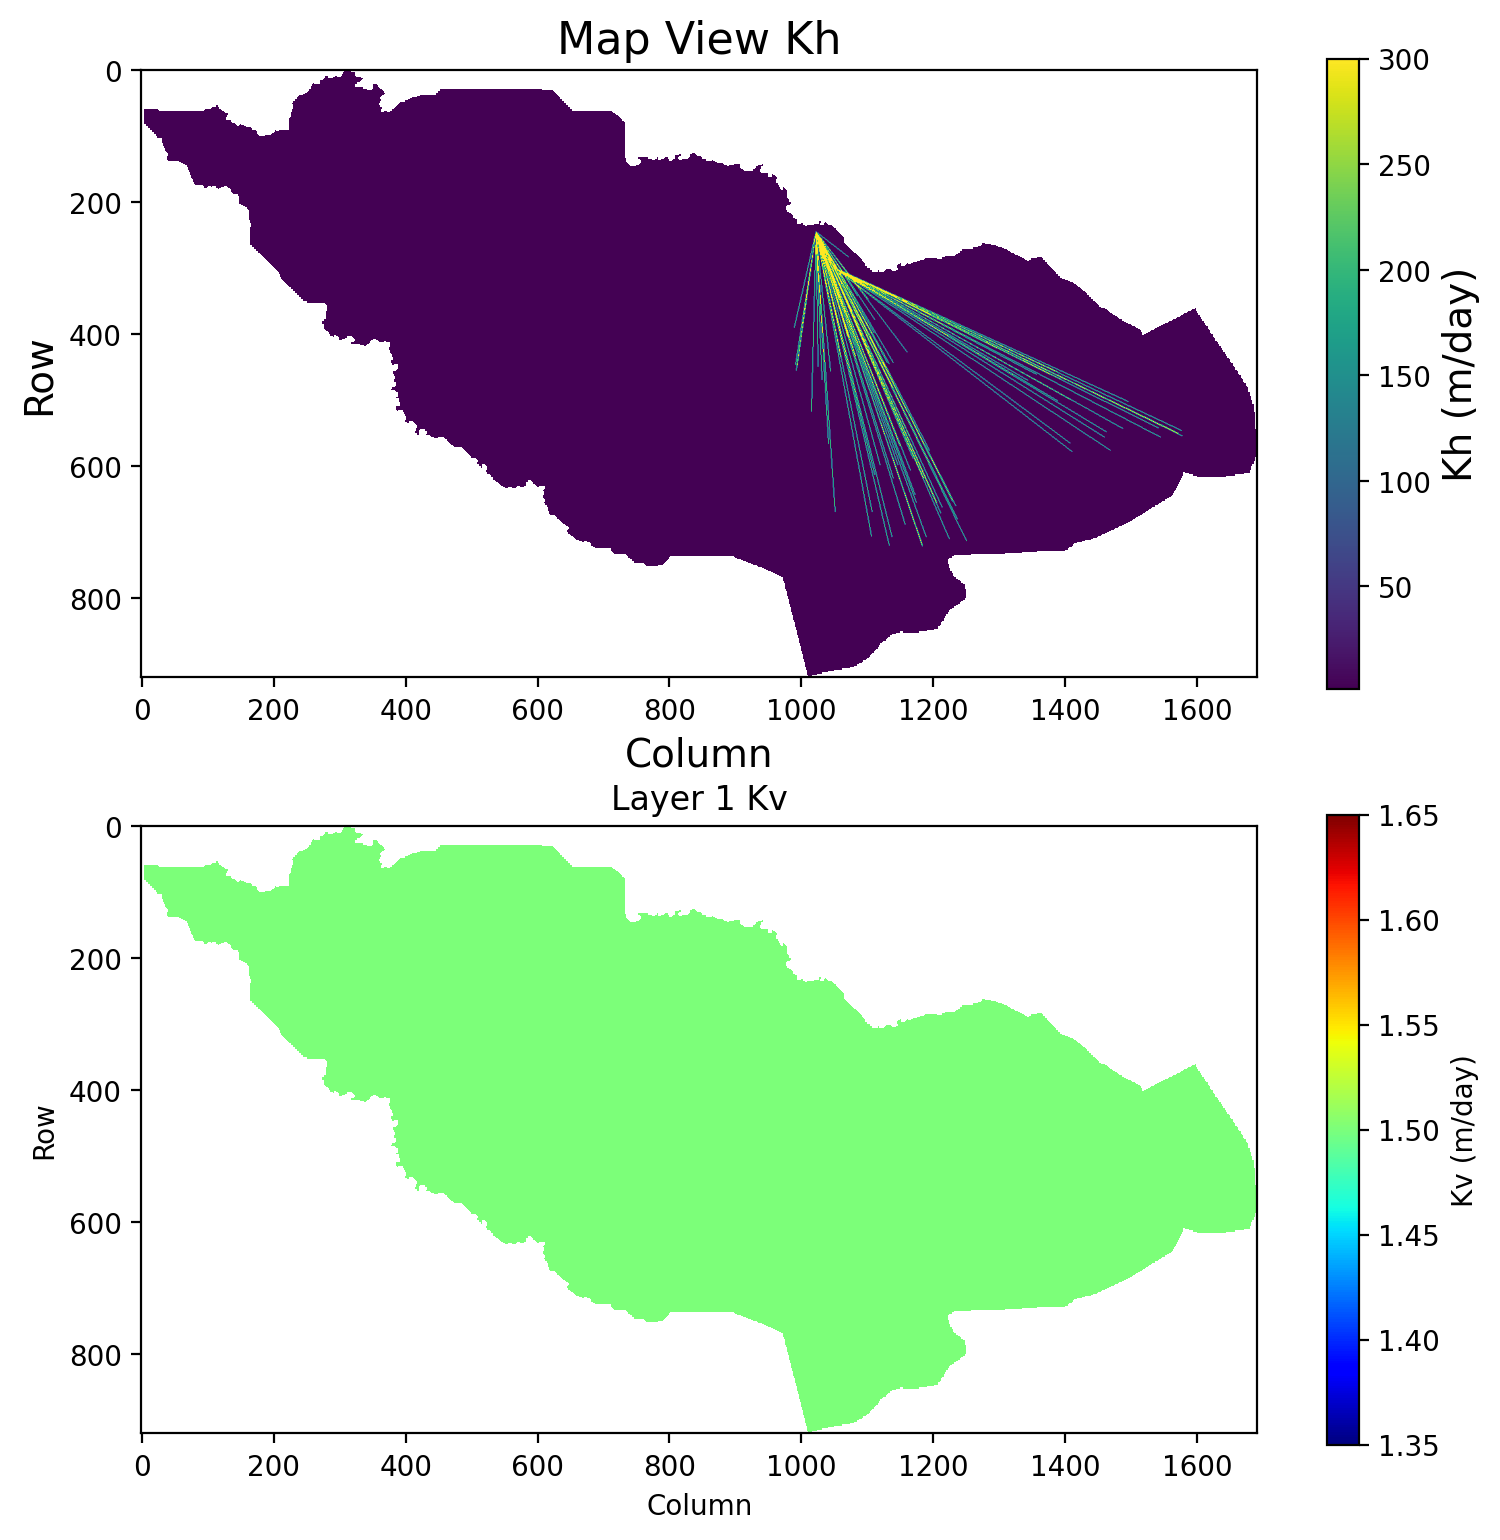

In [128]:
%%time

#Plot the Kh and Kv distributions
k11_view = npf.k.array 
k33_view = npf.k33.array

#mask out the idomain inactive cells from the array
k11_view = np.ma.masked_where(idomain == 0, k11_view)
k33_view = np.ma.masked_where(idomain == 0, k33_view)

#Generate a figure for plotting the Kv and Kh of each of the model layers
fig, axes = plt.subplots(2, nlay, figsize=(9, 9), dpi = 200)

for i in range(nlay):
    #Plot the Kh array in map view
    ax = axes[0]
    ax.set_title(f"Map View Kh", fontsize = 16)
    ax.set_xlabel("Column", fontsize = 14)
    ax.set_ylabel("Row", fontsize = 14)
    im = ax.imshow(k11_view[i], cmap='viridis', origin='upper')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Kh (m/day)', fontsize=14)  # Set label font size
    cbar.ax.tick_params(labelsize=10)  # Set tick label font size
    
    #Plot the Kv Array in map view
    ax = axes[1]
    im = ax.imshow(k33_view[i], cmap='jet', origin='upper')
    ax.set_title(f"Layer {i + 1} Kv")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    fig.colorbar(im, ax=ax, label="Kv (m/day)")

In [129]:
%%time

# write the MODFLOW input files
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_wsgrid...
    writing model name file...
    writing package dis...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 4698 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...
CPU times: user 23.2 s, sys: 115 ms, total: 23.3 s
Wall time: 23.9 s


In [130]:
%%time
#run the MODFLOW simulation
sim.run_simulation(silent= False) #Set silent to False if you want to print out the messages during the simulation run

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 10/18/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 18 2024 02:59:03 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that 

(True, [])

## Post Process the model outputs

In [131]:
%%time

# load the output from the simulation
head = gwf.output.head().get_alldata()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

CPU times: user 23.5 ms, sys: 12 ms, total: 35.5 ms
Wall time: 348 ms


CPU times: user 27.9 s, sys: 626 ms, total: 28.6 s
Wall time: 28.7 s


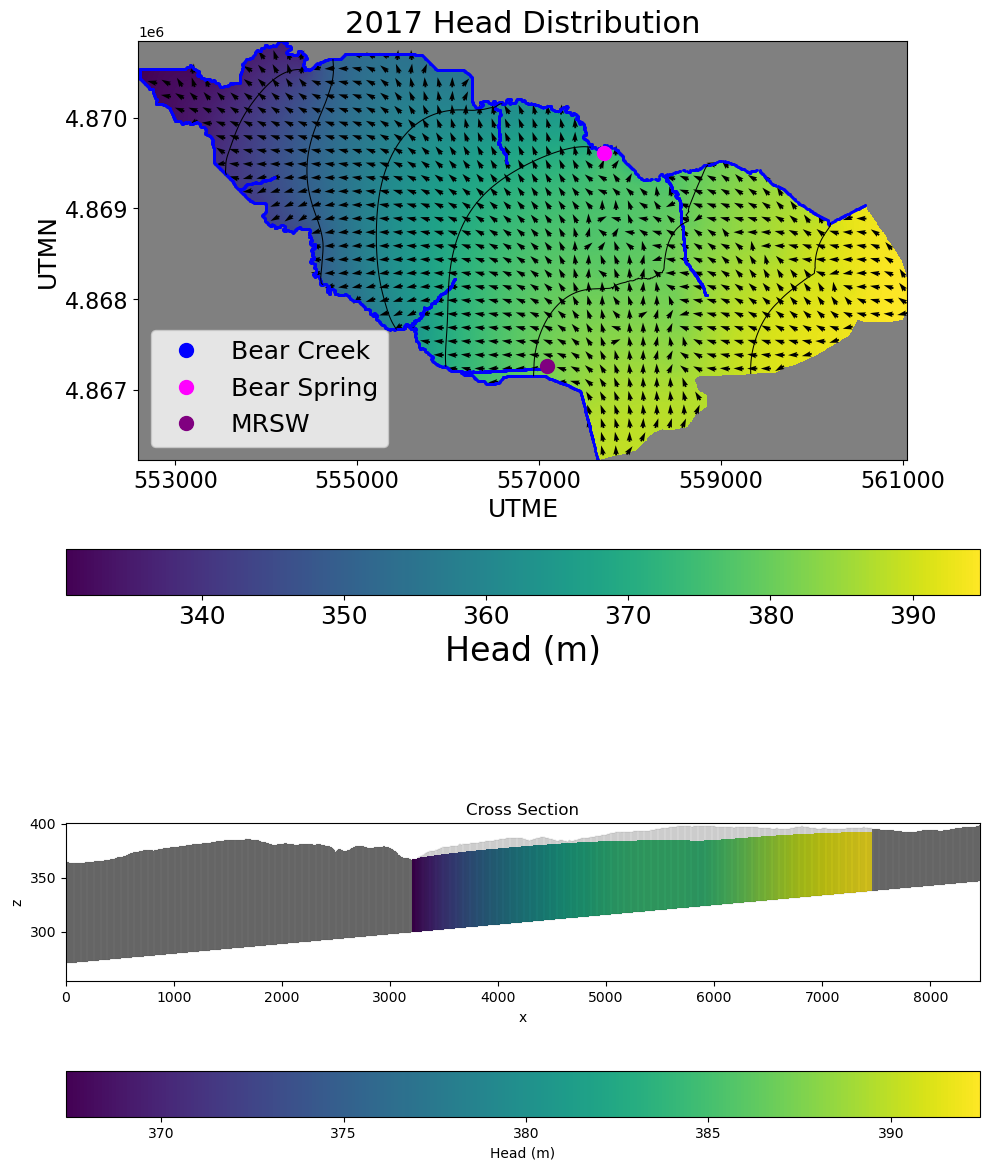

In [132]:
%%time
import matplotlib.lines as mlines

# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
ax = axes[0] 
ax.set_title("2017 Head Distribution", fontsize = 22)
ax.set_aspect(1)
ax.set_xlabel("UTME", fontsize = 18)
ax.set_ylabel("UTMN", fontsize = 18)
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
min_head = np.min(head)
#pmv.plot_bc(ftype="CHD") 
cb = pmv.plot_array(head[0][0]) #plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
#pmv.plot_grid(color="black", linewidth=0.1)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=30, jstep=30)
pmv.contour_array(head[0][0], colors='k', linewidths = 0.75)

cbar = plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
cbar.set_label("Head (m)", fontsize=24)  # Set font size for colorbar label
cbar.ax.tick_params(labelsize=18)  # Set font size for colorbar ticks

# Increase axis tick label font sizes
ax.tick_params(axis='both', which='major', labelsize=16)  # Set axis ticks font size

# Get cell locations for Bear Creek
river_cells = [(cell[1], cell[2]) for cell in all_creek_drains]  # Extract row and column indices from river_drain
river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the Sinkholes in the model
#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the MRS Well in the model: MRSW UTME: 557091, UTMN: 4867265
welli, wellj = sg.intersect(557091, 4867265)

#Get the water table elevation at the MRSW:
MRS_head = head[0][0][welli][wellj]

#Plot the creek, spring, and sinkhole cells on the map
ax.scatter(river_x, river_y, color='blue', s = 1, label = 'Creek Cells') # PLot the river_drain cells
#ax.scatter(spring_x, spring_y, color='magenta', s= 8, label = 'Bear Spring') # PLot the spring_drain cells
ax.scatter(557714, 4869606, color='magenta', label = 'Bear Spring', s = 100)
#ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', label = 'Sinkholes')

#Plot the location of the MRSW on the Plot
ax.scatter(557091, 4867265, color='purple', label = 'MRS Well', s = 100)

# Manually define legend handles with custom marker sizes
legend_handles = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Bear Creek'),
    mlines.Line2D([], [], color='magenta', marker='o', linestyle='None', markersize=10, label='Bear Spring'),
    #mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=8, label='Sinkholes'),
    mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=10, label='MRSW')  # Larger marker
]

ax.legend(handles=legend_handles, loc='lower left', fontsize=18)
ax.set_xticks([553000, 555000, 557000, 559000, 561000])  # Adjust the number of ticks as needed


#ax.legend(loc='lower left', fontsize=15)

#Temporarily disable cross section plotting while using highly discretized grid
ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow*0.75)})
pxs.plot_inactive(color_noflow="gray")
#pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
cb = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.05)
plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
plt.tight_layout()

## Check for Model Errors

CPU times: user 388 ms, sys: 4.02 ms, total: 392 ms
Wall time: 391 ms


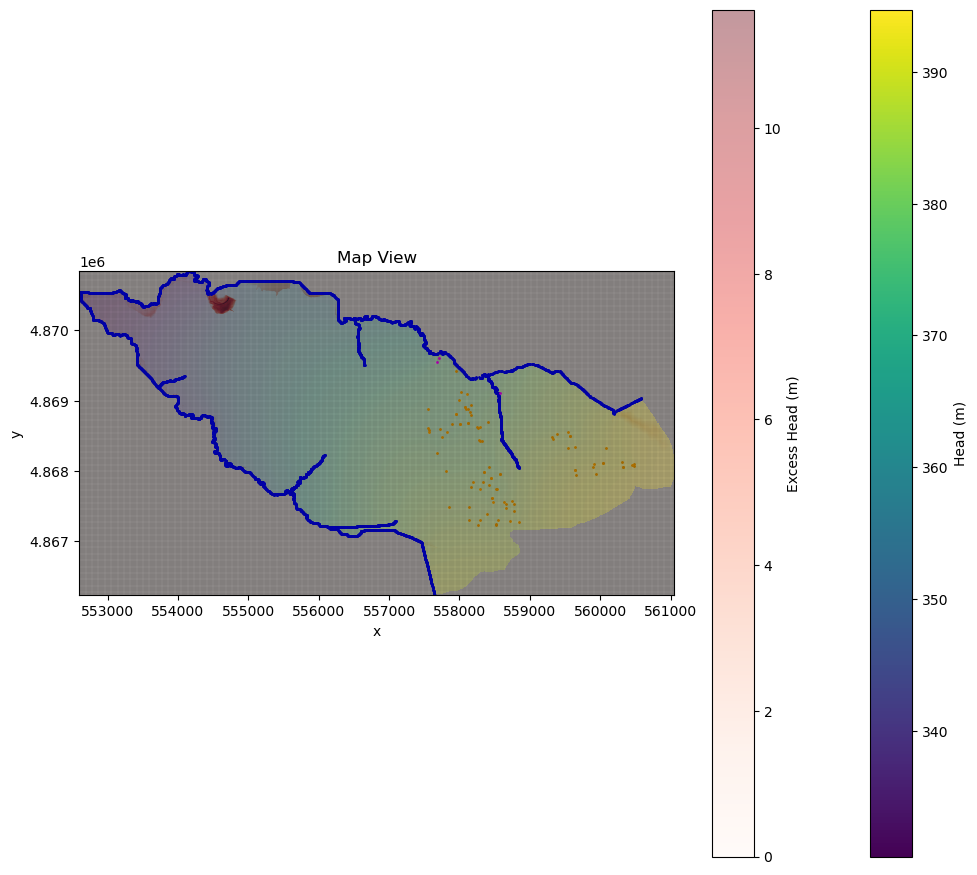

In [133]:
%%time

#Plot the locations where the hydraulic head exceeds the land surface elevation
excess_head_mask = np.zeros_like(head[0][0])
valid_mask = (head[0][0] < 1e30)  # Exclude cells with head >= 1e30
excess_head_mask[(head[0][0] > top) & valid_mask] = 1  # Mark cells with valid excess head

# Create an array to store the head difference
head_difference = np.zeros_like(excess_head_mask)  # Initialize with zeros (or np.nan if preferred)

# Record the head difference where the mask is active
head_difference = head[0][0] - top

head_difference[excess_head_mask == 0 ] = 0

# Plot the model results
fig, axes = plt.subplots(1, 1, figsize=(12, 11))
ax = axes
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Map view plot
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
cb = pmv.plot_array(head[0][0])  # Plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.05)

# Overlay the excess head mask
#pmv.plot_array(excess_head_mask, cmap="Reds", alpha=0.5, label="Excess Head")
cbx = pmv.plot_array(head_difference, cmap = "Reds", alpha = 0.4, label = "Excess Head")

# Plot features
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
#ax.legend(loc='upper right')

plt.colorbar(cb, label="Head (m)")
plt.colorbar(cbx, label = "Excess Head (m)")



In [134]:
#Build a structure that allows for conversion from node convention (e.g. list of cells or objects in a linear fashion)
#To a structure that allows for representing nodes as points in a 3D grid
#Setup for undoing the linear indexing used to assign values to the drian cells

linear_index = 4158

k = linear_index // (nrow * ncol)  # Calculate the layer index
i = (linear_index % (nrow * ncol)) // ncol  # Calculate the row index
j = linear_index % ncol  # Calculate the column index

In [135]:
#Calculate the discharge from Bear Spring

#Get the Bear Spring Coordinates
print(f'The Coordinates for Bear Spring are:{kBS, iBS, jBS}')

#get the discharge from the BS drain and River drains
cbb_file = f"{ws}/{name}.bud"
cbb = flopy.utils.CellBudgetFile(cbb_file)

#Get all of the drain data from the cbb
drn_discharge = cbb.get_data(text='DRN') #retrieve all of the DRN flows

disch_array = np.array(drn_discharge) #convert the nested array to a format where it can actually be read

#calculate the total discharge through bear spring over the entire model, units of L**3
BS_m3 = 0
for i in range(len(disch_array[:,0])): #Bear Spring is the 0th index in the drn_array
    BS_m3 = BS_m3 + disch_array[:,0][i][2] * -1
#BS_m3 = BS_m3 / 24 # ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)
print(f"Total Bear Spring Discharge: {BS_m3:.0f} m³")

#Bear Creek Drain Cells total discharge
BC_m3 = 0 #Initialize the total discharge sum

# Loop over all timesteps (720 timesteps)
for i in range(np.shape(disch_array)[0]):  # Iterate over timesteps (rows of drn_array)
    # Loop over all drains, skipping the 0th drain
    for n in range(1, np.shape(disch_array)[1]):  # Start at n=1 to skip the 0th drain
        # Access the discharge value (3rd element of the tuple)
        BC_m3 += abs(disch_array[i, n][2])  # Add the absolute discharge value
        
#BC_m3 = BC_m3 / 24 #ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)   

# Print the total discharge in cubic meters (m³)
print(f"Total Bear Creek Discharge: {BC_m3:.0f} m³")
total_drain = BC_m3 + BS_m3
print(f"Total System Discharge: {total_drain:.0f} m³")

#Get the head value in the cell that is asssociated with the Galena MRS well to use as an additional calibration check point
print(f'The Water Table Elevation in the MRS well is: {MRS_head} m')
print(f'The Depth to water in the MRS well is: {top[welli][wellj]-MRS_head}')
print(f'The actual avg. depth to water in the MRS well is: {top[welli][wellj] - np.nanmean(obsGWE_df)}')

The Coordinates for Bear Spring are:(0, 246, 1023)
Total Bear Spring Discharge: 3958 m³
Total Bear Creek Discharge: 16356 m³
Total System Discharge: 20314 m³
The Water Table Elevation in the MRS well is: 381.19138537615646 m
The Depth to water in the MRS well is: 0.998800170718539
The actual avg. depth to water in the MRS well is: -433.0078504190824


In [136]:
#Print the difference between the actual value and the modeled value
import statistics
hdiff = np.nanmean(obsGWE_df['gw_elev[m]']) - MRS_head
head_err = abs(hdiff)/np.nanmean(obsGWE_df['gw_elev[m]']) * 100
print(f'The difference between the steady state MRSW head and observed MRSW head {hdiff} m')
print(f'The % Error in the head value is: {head_err} %')
print(f'The difference between the steady state discharge and observed: {dis_avg - BS_m3} m')
dis_err = abs(dis_avg - BS_m3)/dis_avg * 100
#print(f'The percent error in the discharge is: {dis_err} %')
sigma = statistics.stdev(obsGWE_df['gw_elev[m]'])
well_range = [obsGWE_df['gw_elev[m]'].mean()- (sigma), obsGWE_df['gw_elev[m]'].mean() + (sigma)]
head_test = well_range[0] <= MRS_head <= well_range[1]
print(f'the Simulated head is within 1 standard deviation of the measured head: {head_test}')

The difference between the steady state MRSW head and observed MRSW head -0.332462380411755 m
The % Error in the head value is: 0.08729279014830107 %
The difference between the steady state discharge and observed: 6.967490213951805 m
the Simulated head is within 1 standard deviation of the measured head: True


## Implement MODPATH particle tracking at Bear Spring

In [137]:
%%time
#Forward Particle Tracking

#Generate MODPATH files
mpnamf = f"{name}_mp_forward"

#Generate the modpath7 object
mp = flopy.modpath.Modpath7(
    modelname = mpnamf,
    flowmodel = gwf,
    model_ws = ws
)

#Generate a list of particles for release at the cell surfaces
p = [
    (0, i, j)
    for i in range(0, nrow, 10)  # Every 10th row
    for j in range(0, ncol, 10)  # Every 10th column
    if idomain[0, i, j] == 1  # Ensure particles are in active cells
]

#Generate particle data
p = flopy.modpath.ParticleData(p, structured = True)

#Generate A particle Group object
pg = flopy.modpath.ParticleGroup(particledata = p)

#Set particle data to recharge and drain along the top cell face
defaultiface = {"RECHARGE": 6,"DRAIN": 6}
porosity = 0.000015 
mpbas = flopy.modpath.Modpath7Bas(
    mp,
    porosity = porosity,
    defaultiface = defaultiface
)

#Create the simulation object for the modpath7 object
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype = "pathline",
    pathlinefilename = f'mp.pathline7',
    endpointfilename=f"mp.endpoint7",
    trackingdirection="forward",
    #weaksinkoption="pass_through",
    weaksinkoption="stop_at",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    stoptimeoption="extend",
    particlegroups=[pg],
    #zonedataoption="on",
    #stopzone=2,
    #zones=zone_array
)

mp.write_input()
mp.run_model()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mp7

MODPATH Version 7.2.001   
Program compiled Dec 21 2024 11:16:07 with GFORTRAN compiler (ver. 8.5.0 2021)  


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
      5605 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1894 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        
CPU times: 

(True, [])

In [138]:
%%time
#Get all of the tracking pathline data and plot

#load forward tracking pathline data
fpth = pl.Path(ws) / f"mp.pathline7"

#Set the coordinates for the spring and for the creek
spring_cell = (kBS, iBS, jBS)

node_spring = get_nodes([spring_cell])

p = flopy.utils.PathlineFile(fpth)
pw = p.get_destination_pathline_data(dest_cells = node_spring)
pall = p.get_alldata()

#Load forward tracking endpoint data
fpth = pl.Path(ws) / f'mp.endpoint7'

e = flopy.utils.EndpointFile(fpth)

#Get all endpoint data (epd)
all_epd = e.get_alldata()

#Get particles that terminate in wells
spr_epd = e.get_destination_endpoint_data(dest_cells = node_spring)


CPU times: user 35.8 s, sys: 260 ms, total: 36.1 s
Wall time: 37.8 s


In [139]:
#ADjust the endpoint data to be plottable without using the built in flopy tools
mpCellsX = spr_epd['x0'] + bounds[0]#* np.average(delc)
mpCellsY = spr_epd['y0'] + bounds[1]#* np.average(delr)

In [140]:
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

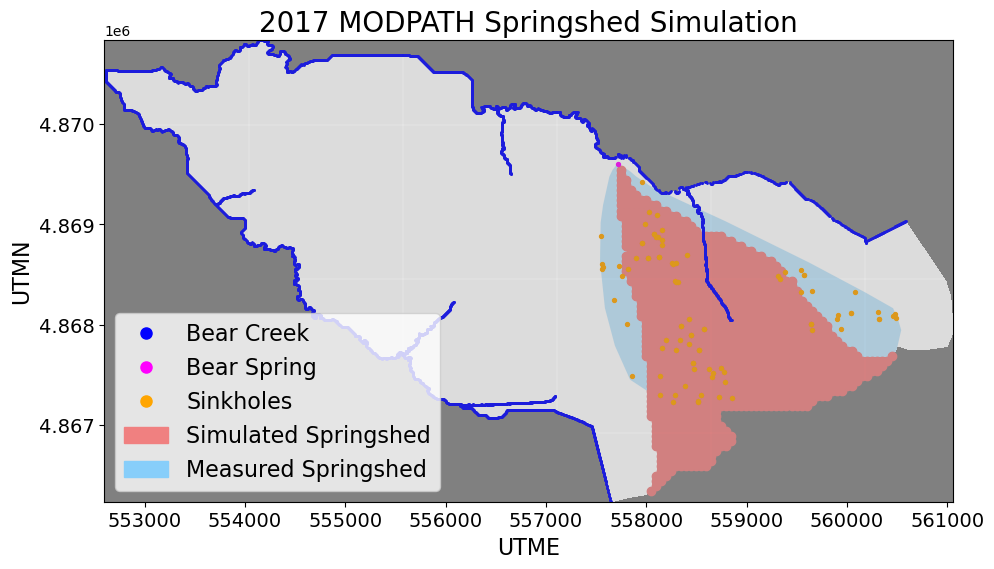

In [141]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1, figsize =(12, 6))
mm = flopy.plot.PlotMapView(model = gwf, ax = ax)
ax.set_title('2017 MODPATH Springshed Simulation', fontsize = 20)
ax.set_xlabel('UTME', fontsize = 16)
ax.set_ylabel('UTMN', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)  # Set axis ticks font size
mm.plot_grid(lw = 0.05)
#mm.plot_endpoint(spr_epd, direction="starting", colorbar=False, shrink=0.5)
mm.plot_inactive(color_noflow="gray")
#Plot the features
bsPolygon.plot(ax=ax, color='lightskyblue', alpha = 0.5, label = 'Measured Springshed')
ax.scatter(mpCellsX, mpCellsY, color = 'lightcoral', alpha = 1, label = 'Simulated Springshed')
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
#ax.scatter(spring_x, spring_y, color='magenta', s=5, label='Springs')
ax.scatter(557714, 4869606, color='magenta', s = 8 , label = 'Bear Spring')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s = 8, label='Sinkholes')

# Manually define legend handles with custom marker sizes
legend_handles = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='Bear Creek'),
    mlines.Line2D([], [], color='magenta', marker='o', linestyle='None', markersize=8, label='Bear Spring'),
    mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=8, label='Sinkholes'),
    mpatches.Patch(color="lightcoral", label="Simulated Springshed"),
    mpatches.Patch(color='lightskyblue', label = 'Measured Springshed')
]

ax.legend(handles=legend_handles, loc='lower left', fontsize=16)

In [142]:
print(f"Number of pathlines to spring: {len(pw)}")
print(f"Number of Cells that contribute to the spring {len(spr_epd)}")

Number of pathlines to spring: 1495
Number of Cells that contribute to the spring 1495


In [143]:
#Calculate the rate of transport between the spring and a specified source cell (NOTE THAT NOT ALL CELLS WILL HAVE A PARTICLE ASSOCIATED! Particles are released every nth step (see above))
sinkholeID = '55D1221' #This can be changed
print(f'The node for Bear Spring is: {node_spring}')

node_source = get_nodes([(0, get_cell_elev(sinkholeID)[1], get_cell_elev(sinkholeID)[2])]) #Get the node for the input sinkhole
print(f'The Sinkhole node is: {node_source}')

#Get the linear distance between the sinkhole and spring, then use the time value in order to calculate the rate of transport

spr_epd_df = pd.DataFrame.from_records(spr_epd)
a = np.where(spr_epd_df['node0'] == node_source[0])[0][0]
x1 = spr_epd_df.iloc[a]['x0']
y1 = spr_epd_df.iloc[a]['y0']
x2 = spr_epd_df.iloc[a]['x']
y2 = spr_epd_df.iloc[a]['y']

linear_distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
tortuous_distance = linear_distance * 1.5
print(f'The linear distance between sinkhole {sinkholeID} and Bear Spring is: {linear_distance} m')

transitTime = spr_epd_df.iloc[a]['time']
#gw_velocity = linear_distance / transitTime
gw_velocity = tortuous_distance/ transitTime

print(f'The Groundwater Velocity from sinkhole {sinkholeID} to Bear Spring is {gw_velocity} m/day')

The node for Bear Spring is: [417255]
The Sinkhole node is: [965590]
The linear distance between sinkhole 55D1221 and Bear Spring is: 1738.0197977709713 m
The Groundwater Velocity from sinkhole 55D1221 to Bear Spring is 8406.40715246596 m/day


## Plot the calibrated parameter values
This pulls data from other notebooks, but it just happened that I produced these plots here, in this notebook

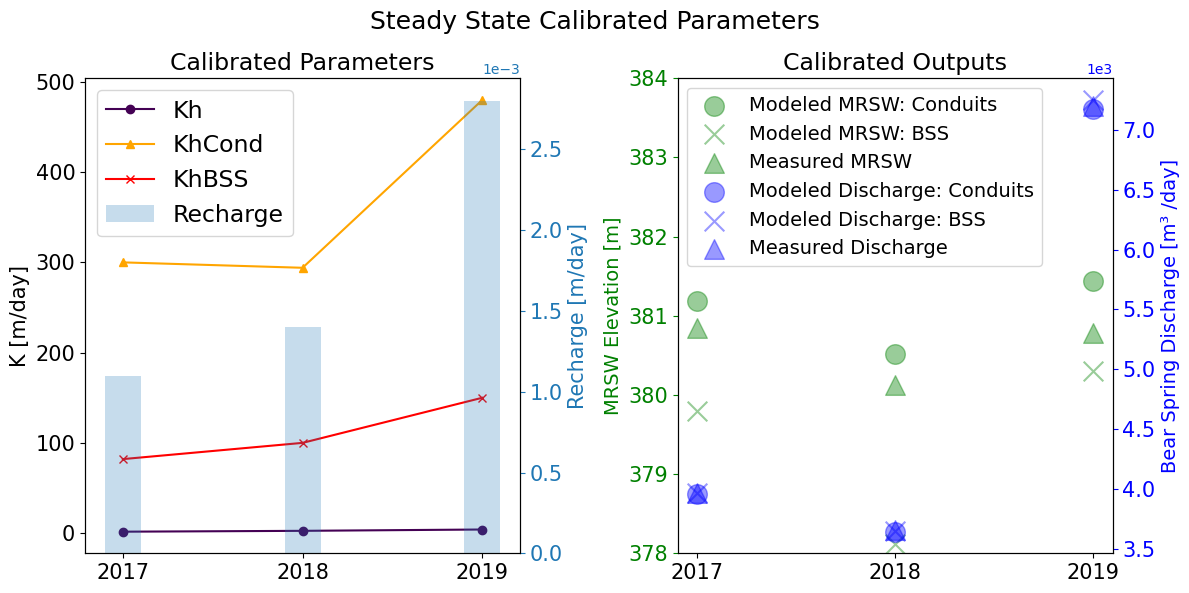

In [144]:
#### Get the input data for input into the plot
simDis = [3958.14, 3641, 7174 ] #m3/day
obsDis = [3965, 3659, 7205] #m3/day
kH = [1.58, 2.53, 4.0 ] # m/day
kHcond = [300, 294, 480] #m/day
simMRSW = [381.19, 380.52, 381.44 ] #m NAVD88
obsMRSW = [380.85, 380.13, 380.78] #m NAVD88
recharge = [0.0011, 0.0014 , 0.0028] #m/day

bppDis = [3961.27, 3648.61, 7252.45 ]
kHbpp = [82, 100, 150]
bppMRSW = [379.8, 378.12, 380.3]

years = (2017, 2018, 2019)

fig, axes = plt.subplots(1, 2, figsize = (12,6))

plt.suptitle('Steady State Calibrated Parameters', fontsize = 18)
ax = axes[0]
ax.set_title('Calibrated Parameters', fontsize = 17)
ax.plot(years, kH, '-o', label = 'Kh', color ="#440154")
ax.set_ylabel('K [m/day]', color = 'k', fontsize = 15)
ax.tick_params(axis = 'y', colors = 'k', labelsize = 15)
ax.set_xticks(years)  # Set only 2017, 2018, 2019 as x-ticks

ax2 = ax.twinx()
ax.plot(years, kHcond, '-^', label = 'KhCond', color = "orange")
ax.plot(years, kHbpp, '-x', label = 'KhBSS', color = 'red')
#ax.set_ylabel('KhCond/KhBPP [m/day]', color = 'orange', fontsize = 14)
#ax2.tick_params(axis="y", colors='orange', labelsize = 12)

#ax3 = ax.twinx()
#ax3.spines["right"].set_position(("outward", 50))
#ax2.plot(years, recharge, '-o', label = 'Recharge [m/day]', color = '#1f77b4')
ax2.bar(years, recharge, label = 'Recharge', color = '#1f77b4', width=0.2, alpha = 0.25)
ax2.set_ylabel('Recharge [m/day]', color ='#1f77b4', fontsize = 15)
ax2.tick_params(axis="y", colors='#1f77b4', labelsize = 15)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.tick_params(axis = 'x', labelsize = 15)

# Collect handles and labels from all axes
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#handles3, labels3 = ax3.get_legend_handles_labels()

# Combine them
all_handles = handles + handles2# + handles3
all_labels = labels + labels2 #+ labels3

# Add legend with all entries
ax.legend(all_handles, all_labels, loc='upper left', fontsize = 17)

ax = axes[1]
ax.set_xticks(years)  # Set only 2017, 2018, 2019 as x-ticks
ax.set_title('Calibrated Outputs', fontsize = 17)
ax.scatter(years, simMRSW, marker = 'o', label = 'Modeled MRSW: Conduits', color = 'green', s = 200, alpha = 0.4)
ax.scatter(years, bppMRSW, marker = 'x', label = 'Modeled MRSW: BSS', color = 'green', s = 200, alpha = 0.4 )
ax.scatter(years, obsMRSW, marker = '^', label = 'Measured MRSW', color = 'green', s = 200, alpha = 0.4)
ax.set_ylabel('MRSW Elevation [m]', fontsize = 14, color = 'green')
ax.tick_params(axis="y", colors='green', labelsize = 15)
ax.set_ylim(378.0, 384.0)

ax2 = ax.twinx()
ax2.scatter(years, simDis, marker = 'o', label = 'Modeled Discharge: Conduits', color = 'b', s = 200, alpha = 0.4)
ax2.scatter(years, bppDis, marker = 'x', label = 'Modeled Discharge: BSS', color = 'b', s = 200, alpha = 0.4)
ax2.scatter(years, obsDis, marker = '^', label = 'Measured Discharge', color = 'b', s = 200, alpha = 0.4)
ax2.set_ylabel('Bear Spring Discharge [m\u00b3 /day]', fontsize = 14, color = 'b')
ax2.tick_params(axis='y', colors = 'b', labelsize = 15)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# Collect handles and labels from all axes
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine them
all_handles = handles + handles2
all_labels = labels + labels2

# Add legend with all entries
ax.legend(all_handles, all_labels, loc='upper left', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 15)

plt.tight_layout()